# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
fileName = '../build/calibration.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 35879


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 10109096


# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)

  0%|          | 0/35879 [00:00<?, ?it/s]

100%|██████████| 29498/29498 [00:00<00:00, 79148.85it/s]


# Make Grid

In [9]:
grid, grid_ind, grid_pos = get_voxelGrid(
    (30, 30, 30),
    DETECTOR_SIZE_MM,
    np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
    np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
    [1 for i in range(len(df_hits))],
    20,
    True
)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_56506/3966560590.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


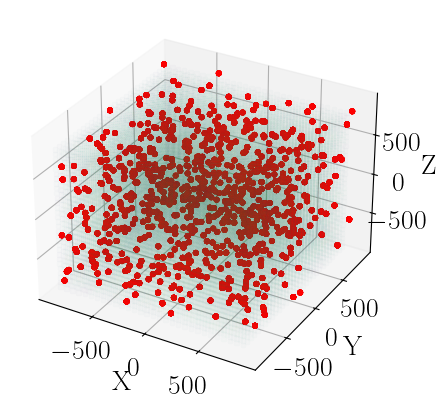

In [10]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track = ax.scatter(np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,0],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,1],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,2],
                   c='r',
                   marker='o',
                   s=5,
                   linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

In [28]:
size = (80, 80, 80)
makeErrors = False
df_hits = make_reconstructedVertex(df_hits, get_voxelGrid, size, DETECTOR_SIZE_MM, makeErrors, type='mean')
df_hits = make_reconstructedVertex(df_hits, get_voxelGrid, size, DETECTOR_SIZE_MM, makeErrors, type='max')

100%|██████████| 845/845 [04:27<00:00,  3.16it/s]


In [29]:
true_mean = np.array(df_hits['initialPosition'         ].to_list()).reshape(-1,3)
reco_mean = np.array(df_hits['reconstructedVertex_mean'].to_list()).reshape(-1,3)
true_mean = true_mean[~np.isnan(reco_mean).any(axis=1)]
reco_mean = reco_mean[~np.isnan(reco_mean).any(axis=1)]
inds_mean = np.unique(reco_mean, axis=0, return_index=True)[1]
true_mean = true_mean[inds_mean]
reco_mean = reco_mean[inds_mean]
distances_mean = np.linalg.norm(true_mean - reco_mean, axis=1)

true_max = np.array(df_hits['initialPosition'        ].to_list()).reshape(-1,3)
reco_max = np.array(df_hits['reconstructedVertex_max'].to_list()).reshape(-1,3)
true_max = true_max[~np.isnan(reco_max).any(axis=1)]
reco_max = reco_max[~np.isnan(reco_max).any(axis=1)]
inds_max = np.unique(reco_max, axis=0, return_index=True)[1]
true_max = true_max[inds_max]
reco_max = reco_max[inds_max]
distances_max = np.linalg.norm(true_max - reco_max, axis=1)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_56506/2810443522.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


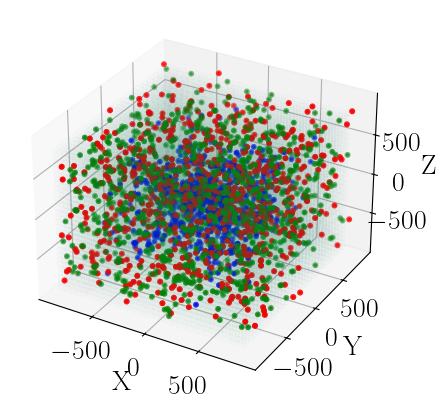

In [30]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
vertex_true = ax.scatter(np.concatenate((true_mean[:,0], true_max[:,0])),
                         np.concatenate((true_mean[:,1], true_max[:,1])),
                         np.concatenate((true_mean[:,2], true_max[:,2])),
                         c='r',
                         marker='o',
                         s=5,
                         linewidth=2)
vertex_mean = ax.scatter(reco_mean[:,0],
                         reco_mean[:,1],
                         reco_mean[:,2],
                         c='b',
                         marker='o',
                         s=5,
                         linewidth=2)
vertex_max = ax.scatter(reco_max[:,0],
                        reco_max[:,1],
                        reco_max[:,2],
                        c='g',
                        marker='o',
                        s=5,
                        linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_56506/383831967.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

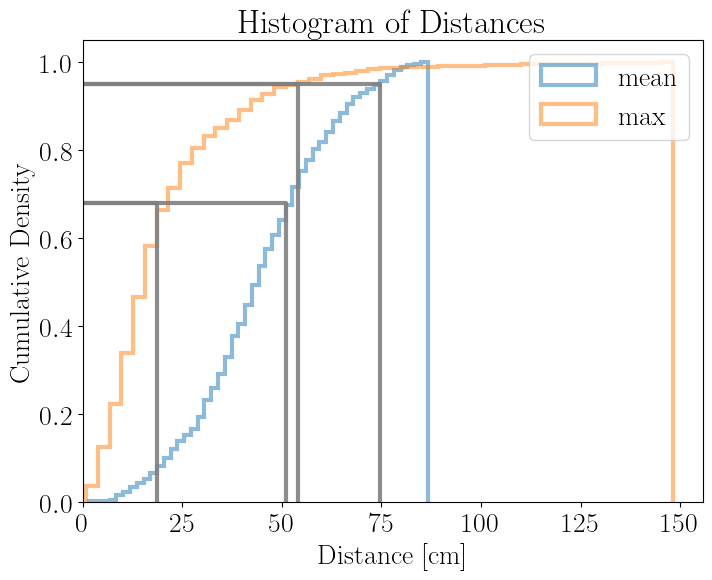

In [31]:
# %matplotlib inline

nBins = 50
scale = 10
lw = 3

PDF, _, _, bins = get_PDF(distances_mean/scale, nBins=nBins)
sigma_1_mean = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_mean = get_CSP('2 sigma', PDF=PDF, bins=bins)

PDF, _, _, bins = get_PDF(distances_max/scale, nBins=nBins)
sigma_1_max = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max = get_CSP('2 sigma', PDF=PDF, bins=bins)

fig, ax = plt.subplots(figsize=(8, 6))
cum = True
ax.hist(distances_mean/scale, bins=nBins, alpha=0.5, histtype='step', cumulative=cum, density=True, label='mean', linewidth=lw)
ax.hist(distances_max /scale, bins=nBins, alpha=0.5, histtype='step', cumulative=cum, density=True, label='max' , linewidth=lw)
ax.plot([sigma_1_mean, sigma_1_mean, 0], [0, 0.68, 0.68], 'gray', linewidth=lw, alpha=0.9)
ax.plot([sigma_2_mean, sigma_2_mean, 0], [0, 0.95, 0.95], 'gray', linewidth=lw, alpha=0.9)
ax.plot([sigma_1_max , sigma_1_max , 0], [0, 0.68, 0.68], 'gray', linewidth=lw, alpha=0.9)
ax.plot([sigma_2_max , sigma_2_max , 0], [0, 0.95, 0.95], 'gray', linewidth=lw, alpha=0.9)
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
ax.legend(loc='upper right')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_56506/2547133240.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


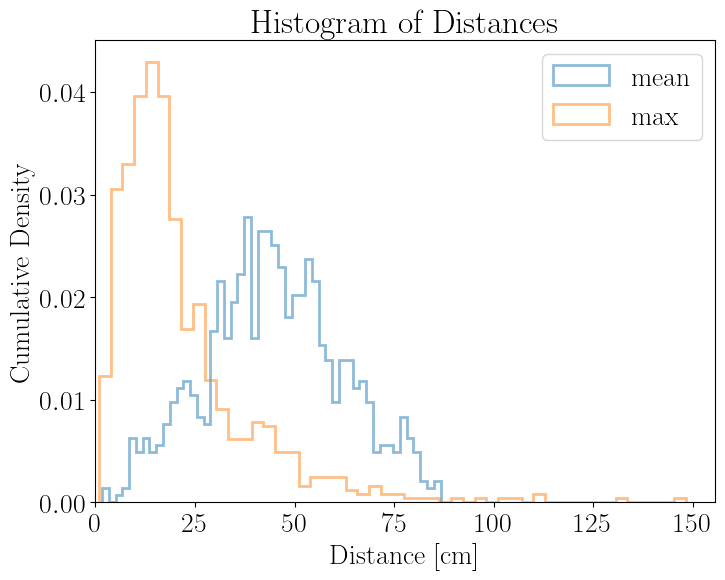

In [32]:
# %matplotlib inline

scale = 10

fig, ax = plt.subplots(figsize=(8, 6))
cum = False
ax.hist(distances_mean/scale, bins=50, alpha=0.5, histtype='step', cumulative=cum, density=True, linewidth=2, label='mean')
ax.hist(distances_max /scale, bins=50, alpha=0.5, histtype='step', cumulative=cum, density=True, linewidth=2, label='max' )
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
ax.legend(loc='upper right')
fig.show()